# Modules

In [1]:
from graphviz import *
from sklearn.datasets import load_iris
from sklearn import tree

from collections import Counter
from itertools import chain, combinations

import ast
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import graphviz
import seaborn as sns

# Helper Tools

In [2]:
class Node:
    def __init__(self,nodeId, label, isRoot=False,parentNode=None,
               leftNode=None,rightNode=None,isTerminal=False, 
                 attr={}):
        self.nodeId = nodeId ## 노드 식별 아이디
        self.label = label ## 노드 텍스트
        self.attr = attr ## 노드 스타일 속성
        self.isRoot = isRoot ## 루트 노드 여부
        self.parentNode = parentNode ## 부모 마디(노드)
        self.leftNode = leftNode ## 왼쪽 자식 노드(마디)
        self.rightNode = rightNode ## 오른쪽 자식 노드
        self.isTerminal = isTerminal ## 터미널 노드 여부
        self.level = 0 ## 노드가 속한 층
        
def visualize_tree(tree):
    def add_node_edge(tree, dot=None):
        if dot is None:
            dot = Digraph()
#             name = tree
            dot.node(name = str(tree.nodeId), label = str(tree.label), **tree.attr)

        ## left
        if tree.leftNode:
            dot.node(name=str(tree.leftNode.nodeId),label=str(tree.leftNode.label),
                     **tree.leftNode.attr) 
            dot.edge(str(tree.nodeId), str(tree.leftNode.nodeId),
                     **{'taillabel':"yes",'labeldistance':'2.5'})
            dot = add_node_edge(tree.leftNode, dot)
            
        if tree.rightNode:
            dot.node(name=str(tree.rightNode.nodeId),label=str(tree.rightNode.label),
                     **tree.rightNode.attr)
            dot.edge(str(tree.nodeId), str(tree.rightNode.nodeId),
                    **{'headlabel':" no",'labeldistance':'2'})
            dot = add_node_edge(tree.rightNode, dot)

        return dot
        
    dot = add_node_edge(tree)
    
    return dot

def RGBtoHex(vals, rgbtype=1):
    """Converts RGB values in a variety of formats to Hex values.

     @param  vals     An RGB/RGBA tuple
     @param  rgbtype  Valid valus are:
                          1 - Inputs are in the range 0 to 1
                        256 - Inputs are in the range 0 to 255

     @return A hex string in the form '#RRGGBB' or '#RRGGBBAA'
    """

    if len(vals)!=3 and len(vals)!=4:
        raise Exception("RGB or RGBA inputs to RGBtoHex must have three or four elements!")
    if rgbtype!=1 and rgbtype!=256:
        raise Exception("rgbtype must be 1 or 256!")

    #Convert from 0-1 RGB/RGBA to 0-255 RGB/RGBA
    if rgbtype==1:
        vals = [255*x for x in vals]

    #Ensure values are rounded integers, convert to hex, and concatenate
    return '#' + ''.join(['{:02X}'.format(int(round(x))) for x in vals])

def is_integer_num(n):
    if isinstance(n, int):
        return True
    if isinstance(n, float):
        return n.is_integer()
    return False

class DecisionTree:
    def __init__(self, tree_type='classification',):
        tree_types = ['classification','regression']
        assert tree_type in tree_types, f'tree_type must be the one of the {tree_types}'
        self.tree_type = tree_type ## 트리 유형
        self.impurity_measure = None ## 불순도 측도
        self.root = None ## 트리 노드
        self.node_id = 0 ## 노드 아이디
        self.col_names = None ## 칼럼 이름
        self.col_types = None ## 변수 타입
        self.X = None ## train data X
        self.y = None ## train data y
        self.leaf_attr = None ## 끝마디 스타일 속성
    
    def traverseInOrder(self, node):
        res = []
        if node.leftNode != None:
            res = res + self.traverseInOrder(node.leftNode)
        res.append(node)
        if node.rightNode != None:
            res = res + self.traverseInOrder(node.rightNode)
        return res
    
    def getDepth(self, root):
        res = self.traverseInOrder(root)
        res = [abs(node.level) for node in res]
        return max(res)
    
    def getLevel(self, node, counter = 1):
        if node.parentNode is None:
            return counter
        else:
            counter += 1
            counter = self.getLevel(node.parentNode,counter)
        return counter
    
    def determineTypeOfCol(self,X, num_unique_values_threshold=15):
        col_types = []
        for col in X.columns:
            unique_values = X[col].unique()
            example_value = unique_values[0]
            
            if (isinstance(example_value, str)) or (len(unique_values) <= num_unique_values_threshold):
                col_types.append('categorical')
            else:
                col_types.append('continuous')
        self.col_types = col_types

    def isPure(self,y):
        if len(np.unique(y)) > 1:
            return False
        return True
    
    def impurity(self, left_y, right_y):
#         impurity_val = 'no'
#         if self.impurity_measure == 'entropy':
#             n = len(left_y)+len(right_y)
#             pl, pr = len(left_y)/n, len(right_y)/n
#             impurity_val = pl*self.individualImpurity(left_y)+\
#                             pr*self.individualImpurity(right_y)
#         elif self.impurity_measure == 'gini':
#             n = len(left_y)+len(right_y)
#             pl, pr = len(left_y)/n, len(right_y)/n
#             impurity_val = pl*self.individualImpurity(left_y)+\
#                             pr*self.individualImpurity(right_y)
#         elif self.impurity_measure == 'mse':
        y = self.y
        n = len(left_y)+len(right_y)
        
        if self.impurity_measure == 'chi2':
            try:
                label = np.unique(y)
                contingency_table = dict()
                expected_table = dict()
                for l in label:
                    temp1 = []
                    temp1.append(np.sum(left_y==l))
                    temp1.append(np.sum(right_y==l))
                    contingency_table[l] = temp1
                    temp2 = []
                    temp2.append((np.sum(left_y==l) + np.sum(right_y==l))*len(left_y)/n)
                    temp2.append((np.sum(left_y==l) + np.sum(right_y==l))*len(right_y)/n)
                    expected_table[l] = temp2

                observed = np.array([v for k,v in contingency_table.items()]).flatten()
                expected = np.array([v for k,v in expected_table.items()]).flatten()
                impurity_val = np.nansum(np.square(observed-expected)/expected)
            except RuntimeWarning:
                raise
        else:
            pl, pr = len(left_y)/n, len(right_y)/n
            impurity_val = pl*self.individualImpurity(left_y)+\
                            pr*self.individualImpurity(right_y)
        return impurity_val
            
    def individualImpurity(self, y):
        if self.impurity_measure == 'entropy':
            return self._entropy(y)
        elif self.impurity_measure == 'gini':
            return self._gini(y)
        elif self.impurity_measure == 'mse':
            return self._mse(y)
    
    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        ps = counts / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])
    
    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        ps = counts / len(y)
        return np.sum([p*(1-p) for p in ps if p > 0])
    
    def _mse(self, y):
        if len(y) == 0:
            return 0
        mse = np.mean(np.square(y-np.mean(y)))
        return mse
    
    def createLeaf(self, y, tree_type):
        if tree_type == 'classification':
            classes, counts = np.unique(y, return_counts=True)
            index = counts.argmax()
            return classes[index]
        else:
            return np.mean(y)
    
    def powerset_generator(self, i):
        for subset in chain.from_iterable(combinations(i, r) for r in range(len(i)+1)):
            yield set(subset)
        
    def splitSet(self, x):
        ps = [i for i in self.powerset_generator(x) if i != set() and len(i) != len(x)]
        idx = int(len(ps)/2)
        split_set = []
        for j in range(idx):
            split_set.append(tuple(ps[j]))
        return split_set
        
    def getPotentialSplits(self,X):
        potential_splits = {}
        col_types = self.col_types
        for col_idx in range(X.shape[1]):
            unique_value = np.unique(X[:,col_idx])
            if col_types[col_idx] == 'continuous':
                potential_splits[col_idx] = unique_value
            else:
                potential_splits[col_idx] = self.splitSet(unique_value)
        return potential_splits
    
    def split(self, X, col_idx, threshold):
        X_col = X[:,col_idx]
        col_types = self.col_types
        if col_types[col_idx] == 'continuous':
            left_idx = np.argwhere(X_col<=threshold).flatten()
            right_idx = np.argwhere(X_col>threshold).flatten()
        else:
            left_idx = np.argwhere(np.isin(X_col,threshold)).flatten()
            right_idx = np.argwhere(~np.isin(X_col,threshold)).flatten()
        return left_idx, right_idx
    
    def determinBestSplit(self, X, y, potential_splits):
        best_split_column, best_split_value, opt_impurity = '', '', ''
        if self.impurity_measure in ['entropy','gini','mse']: 
            opt_impurity = np.infty
            for col in potential_splits:
                for val in potential_splits[col]:
                    left_idx, right_idx = self.split(X,col,val)
                    cur_impurity = self.impurity(y[left_idx],y[right_idx])
                    if cur_impurity <= opt_impurity:
                        opt_impurity = cur_impurity
                        best_split_column = col
                        best_split_value = val
        else:
            opt_impurity = -np.infty
            for col in potential_splits:
                for val in potential_splits[col]:
                    left_idx, right_idx = self.split(X,col,val)
                    cur_impurity = self.impurity(y[left_idx],y[right_idx])
                    if cur_impurity >= opt_impurity:
                        opt_impurity = cur_impurity
                        best_split_column = col
                        best_split_value = val

        return best_split_column, best_split_value, opt_impurity
        
    def fit(self,X,y,impurity_measure='entropy',min_sample=5, max_depth=5, 
            type_of_col=None, auto_determine_type_of_col=True,
            num_unique_values_threshold = 15
           ):
        '''
        impurity_measure : 불순도 측도
        min_sample : 노드가 포함해야하는 최소 샘플 개수,
        max_depth : 나무 최대 깊이 설정
        type_of_col : 변수 타입 리스트
        auto_determine_type_of_col : 변수 타입 자동 생성 여부
        num_unique_values_threshold : 범주형으로 지정할 최대 유니크 원소 개수
        '''
        self.X = X
        self.y = y
        ### 랜덤으로 칼럼 선택하는 것도 고르자. X = X[random_indices,:]
#         if type_of_col is None:
#             type_of_col = determinTypeOfCol(X)
        if auto_determine_type_of_col:
            self.determineTypeOfCol(X, num_unique_values_threshold)
        else:
            if type_of_col is None:
                raise ValueError('When auto_determine_type_of_col is False, then type_of_col must be specified')
            assert X.shape[1] == len(type_of_col), 'type_of_col has the same length of X columns'
            give_type_of_col = list(set(type_of_col))
            for toc in give_type_of_col:
                if toc != 'categorical' and toc != 'continuous':
                    raise ValueError('type_of_col must contain categorical or continuous')
            self.col_types = type_of_col
            
        tree_type = self.tree_type
        impurity_measures = ['entropy','gini','chi2'] if tree_type == 'classification' else ['mse']
        assert impurity_measure in impurity_measures,\
                f'impurity_measure must be the one of the {impurity_measures}'
        self.impurity_measure = impurity_measure
        tree_type = self.tree_type
        self.root = self._growTree(X,y,tree_type,min_sample=min_sample, max_depth=max_depth)
        
        ### assign node a style
        iod = self.traverseInOrder(self.root)
        root_node = [node for node in iod if node.nodeId == 1][0]
        root_node.isRoot = True
        ## set node level
        for nd in iod:
            nd.level = self.getLevel(nd)
        
        colors = sns.color_palette('hls', self.getDepth(self.root))
        
        ## set node level
        if tree_type == 'classification':
            leaf_color = sns.color_palette('pastel', len(np.unique(y)))
#             class_to_color = dict()
#             for i, l in enumerate(np.unique(y)):
#                 class_to_color[l] = RGBtoHex(leaf_color[i])
            leaf_attr = dict()
            for i, l in enumerate(np.unique(y)):
                leaf_attr[l] = {'shape':'box', 'color':f'{RGBtoHex(leaf_color[i])}', 
                                       'fontcolor':f'{RGBtoHex(leaf_color[i])}','peripheries':'2'}
            self.leaf_attr = leaf_attr
        for l in range(1,self.getDepth(self.root)+1):
            color = RGBtoHex(colors[l-1])
            for nd in iod:
                if nd.level == l:
                    if nd.isTerminal:
                        if tree_type == 'classification':
                            nd.attr =  leaf_attr[nd.label]
#                             nd.attr = {'shape':'box', 'color':f'{class_to_color[nd.label]}', 
#                                        'fontcolor':f'{class_to_color[nd.label]}','peripheries':'2'}
                        else:
                            nd.attr = {'shape':'box','peripheries':'2'}
                    else:
                        nd.attr = {'shape':'box','style':'filled',
                                   'fillcolor':f'{color}'}
        
    def _growTree(self, X, y, tree_type, counter=0, min_sample=5, max_depth=5): ## Tree 배고 노드 클래스만 가지고 해야겠다.
        self.node_id += 1
        
        if counter == 0:
            global col_names
#             col_types = self.col_types
            col_names = X.columns
            self.col_names = X.columns
            if isinstance(X, pd.DataFrame):
                X = X.values
            if isinstance(y, pd.Series):
                y = y.values
        else:
            X = X
        if (self.isPure(y)) or (len(y) <= min_sample) or (counter == max_depth):
            leaf = self.createLeaf(y, tree_type)
            if isinstance(leaf, float):
                if not leaf.is_integer():
                    leaf = round(leaf,2)
            return Node(self.node_id, label=leaf, isTerminal=True)

        else:
            counter += 1
            potential_splits = self.getPotentialSplits(X)
            best_split_column, best_split_value, opt_impurity =\
                self.determinBestSplit(X, y, potential_splits)
            opt_impurity = round(opt_impurity,4)
            left_idx, right_idx = self.split(X,best_split_column,best_split_value)
            
            ## check for empty data
            if len(left_idx) == 0 or len(right_idx) == 0:
                leaf = self.createLeaf(y, tree_type)
                if isinstance(leaf, float):
                    if not leaf.is_integer():
                        leaf = round(leaf,2)
                return Node(self.node_id, label=round(leaf,4), isTerminal=True)
            
            total_sample = len(y)
            
            col_name = col_names[best_split_column]
#             if self.tree_type == 'classification':
            if self.col_types[best_split_column] == 'continuous':
                question = f'{col_name} <= {best_split_value}\n'+\
                            f'{self.impurity_measure} : {opt_impurity}\n'+\
                            f'Samples : {total_sample}'
            else:
                question = f'{col_name} in {best_split_value}\n'+\
                            f'{self.impurity_measure} : {opt_impurity}\n'+\
                            f'Samples : {total_sample}'
#             sub_tree = {question:[]}
            node = Node(self.node_id, label=question)
            
            left_child = self._growTree(X[left_idx,:],y[left_idx],tree_type,counter, min_sample, max_depth)  
            right_child = self._growTree(X[right_idx,:],y[right_idx],tree_type,counter, min_sample, max_depth)
            

            if left_child.label == right_child.label:
                node = left_child
            else:
                node.leftNode = left_child
                node.rightNode = right_child
                left_child.parentNode = node
                right_child.parentNode = node

            return node
    
    def predict(self,X):
        return np.array([self._traverse_tree(x, self.root) for _, x in X.iterrows()])
    
    def _traverse_tree(self, x, node):
        if node.isTerminal:
            if isinstance(node.label, str):
                node.label = node.label.replace('\n','')
            return node.label
        
        question = node.label.split('\n')[0]
        
        if ' <= ' in question:
            col_name, value = question.split(' <= ')
            if x[col_name] <= float(value):
                return self._traverse_tree(x, node.leftNode)
            return self._traverse_tree(x, node.rightNode)
        else:
            col_name, value = question.split(' in ')
            if x[col_name] in ast.literal_eval(value):
                return self._traverse_tree(x, node.leftNode)
            return self._traverse_tree(x, node.rightNode)
        
    def pruning(self, node, X_val, y_val):
        X = self.X
        y = self.y
        if isinstance(y, pd.Series):
            y = y.values
        return self._pruning(node, X, y, X_val, y_val)
    
    def _filterX(self, X, node):
        question = node.label.split('\n')[0]
        if ' <= ' in question:
            col_name, value = question.split(' <= ')
            yes_index = X.loc[X[col_name] <= float(value)].index
            no_index = X.loc[X[col_name] > float(value)].index
        else:
            col_name, value = question.split(' in ')
            yes_index = X.loc[X[col_name].isin(ast.literal_eval(value))].index
            no_index = X.loc[~X[col_name].isin(ast.literal_eval(value))].index
        return yes_index, no_index
    
    def _pruning_leaf(self, node, X, y, X_val, y_val):
        if self.tree_type == 'classification':
            classes, counts = np.unique(y, return_counts=True)
            index = counts.argmax()
            leaf = classes[index]
            errors_leaf = np.sum(y_val != leaf)
            errors_decision_node = np.sum(y_val != self.predict(X_val)) ##<---self로 바꿔야해
            if errors_leaf <= errors_decision_node:
                if isinstance(leaf, float):
                    if not leaf.is_integer():
                        leaf = round(leaf,2)
                return Node(node.nodeId, label=leaf, isTerminal=True,
                            attr=self.leaf_attr[leaf])
            else:
                return node
        else:
            return
    
    def _pruning(self, node, X, y, X_val, y_val):
#         assert self.root is not None, 'you must fit first'
        X = X.reset_index(drop=True)
        left_child = node.leftNode
        right_child = node.rightNode
        if node.leftNode.isTerminal == True and node.rightNode.isTerminal == True:
            return self._pruning_leaf(node, X, y, X_val, y_val)
        else:
            if self.tree_type == 'classification':
                tr_yes_idx, tr_no_idx = self._filterX(X, node)
                val_yes_idx, val_no_idx = self._filterX(X_val, node)
                
                if node.leftNode.isTerminal == False:
                    left_child = self._pruning(node.leftNode, X.loc[tr_yes_idx], y[tr_yes_idx],
                                  X_val.loc[val_yes_idx], y_val[val_yes_idx])
#                     node.leftNode = left_child
#                     left_child.parentNode = node
                if node.rightNode.isTerminal == False:
                    right_child = self._pruning(node.rightNode, X.loc[tr_no_idx], y[tr_no_idx],
                                  X_val.loc[val_no_idx], y_val[val_no_idx])
                
#                     node.rightNode = right_child
#                     right_child.parentNode = node
#                 question = node.label.split('\n')[0]
                attr = node.attr
                node = Node(node.nodeId, label=node.label, isTerminal=node.isTerminal)
                node.attr = attr
                node.leftNode = left_child
                left_child.parentNode = node
                node.rightNode = right_child
                right_child.parentNode = node
            else:
                return
        return self._pruning_leaf(node, X, y, X_val, y_val)

# Iris Data

## Load Data

In [3]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = [iris.target_names[x] for x in iris.target]
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Model

In [4]:
X, y = df.iloc[:,:4], df['species'].values
clf = DecisionTree()
clf.fit(X,y, max_depth=3, type_of_col=['continuous']*4,
        auto_determine_type_of_col=False)

## Visualize

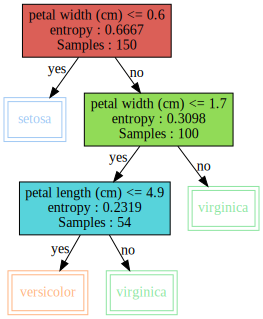

In [5]:
visualize_tree(clf.root)

## Test

In [6]:
np.sum(y == clf.predict(X))/len(y)

0.9733333333333334

## Using SKlearn

In [7]:
X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=5)
clf = clf.fit(X, y)

In [8]:
np.sum(y == clf.predict(X))/len(y)

0.9733333333333334

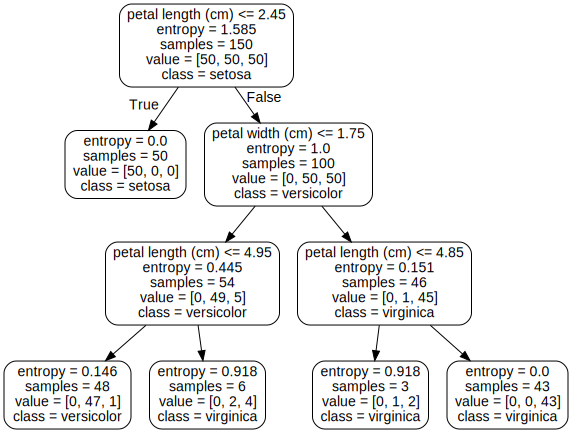

In [11]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=iris.feature_names,  
                     class_names=iris.target_names,  
                     filled=False, rounded=True,  
                     special_characters=False)  
graph = graphviz.Source(dot_data)  
graph 

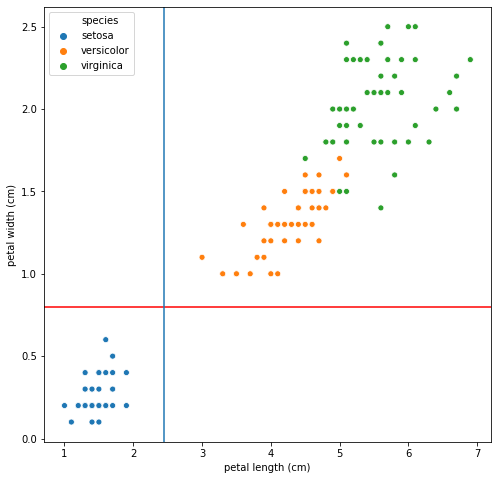

In [27]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
sns.scatterplot(x='petal length (cm)', 
                y='petal width (cm)',
                hue = 'species',
                data=df
               )
plt.axhline(0.8, color='red')
plt.axvline(2.45)
plt.show()

# Titanic Data

## Load Data

In [13]:
df = pd.read_csv('../dataset/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Handle Missing Data

In [14]:
median_age = df['Age'].median()
mode_embarked = df['Embarked'].mode()[0]
df = df.fillna({'Age':median_age, 'Embarked':mode_embarked})

## Model

In [15]:
X = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
y = df['Survived'].values

In [16]:
clf = DecisionTree()
clf.fit(X,y,max_depth=4)

## Visualize

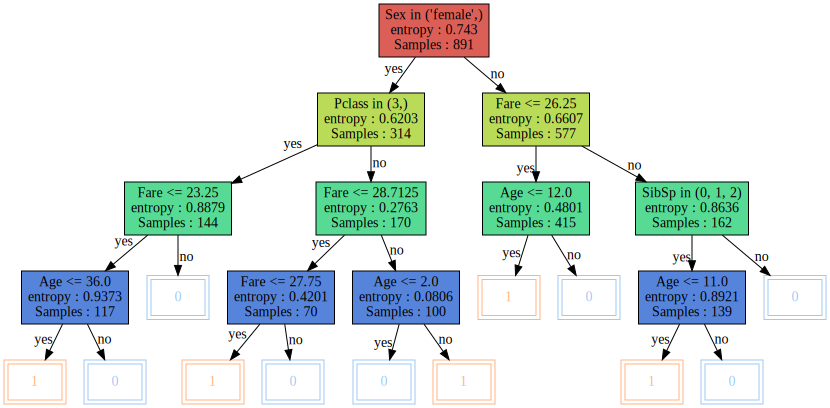

In [19]:
visualize_tree(clf.root)

In [18]:
dot = visualize_tree(clf.root)
dot.format = 'png'
dot.render(filename='titanic_tree', directory='./', cleanup=True)

'.\\titanic_tree.png'

## Test

In [20]:
np.sum(y == clf.predict(X))/len(y)

0.8383838383838383

## Using Sklearn - only continuous variables

In [22]:
X = df[['Age', 'Fare']]
y = df['Survived']

In [23]:
myclf = DecisionTree()
myclf.fit(X,y,impurity_measure='gini',type_of_col=['continuous']*2, max_depth=4)

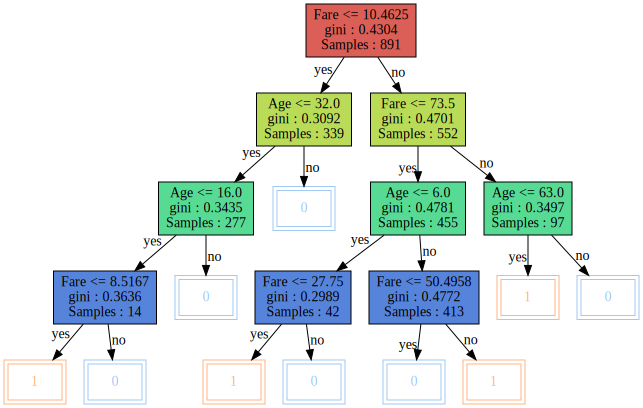

In [24]:
visualize_tree(myclf.root)

In [25]:
np.sum(y == myclf.predict(X))/len(y)

0.7093153759820426

In [26]:
clf = tree.DecisionTreeClassifier(max_depth=4, min_samples_split=5)
clf = clf.fit(X, y)

In [27]:
np.sum(y == clf.predict(X))/len(y)

0.7093153759820426

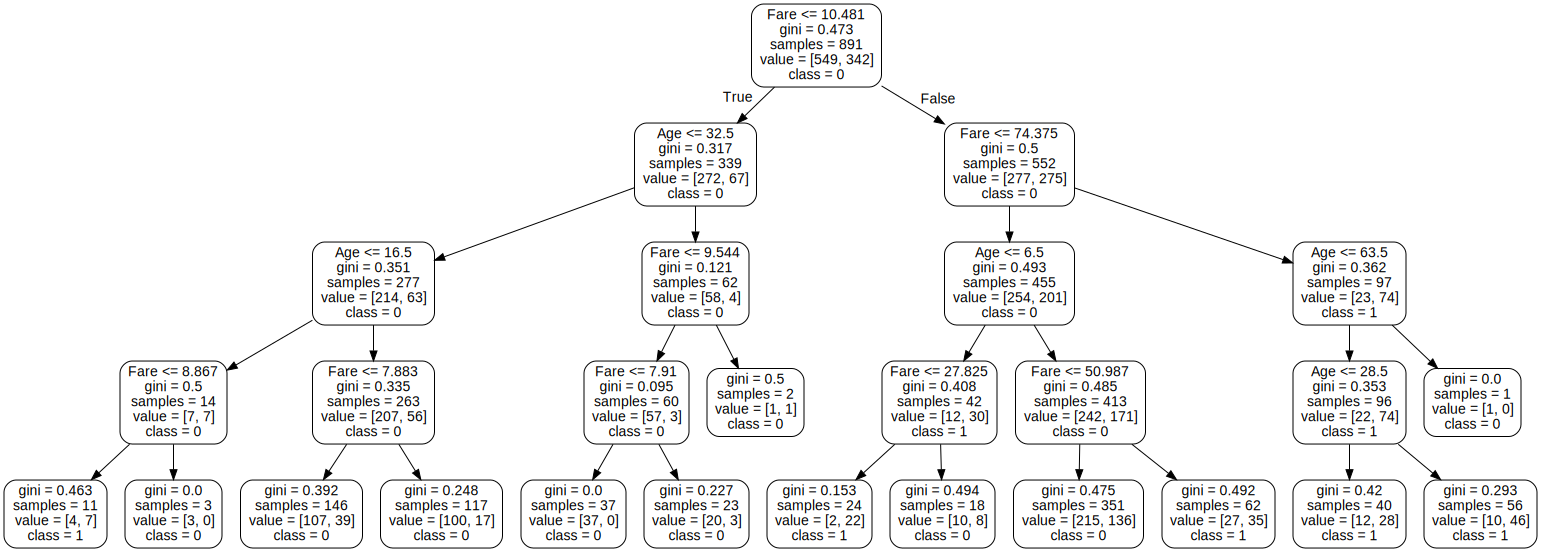

In [29]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=X.columns,  
                     class_names=[str(x) for x in np.unique(y)],  
                     filled=False, rounded=True,  
                     special_characters=False)  
graph = graphviz.Source(dot_data)
graph

In [32]:
graph.format = 'png'
graph.render(filename='titanic_tree_sk', directory='./', cleanup=True)

'.\\titanic_tree_sk.png'

# Bike Shares Data

## Load Data

In [37]:
df = pd.read_csv('../dataset/bike_share.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## Preprocessing

In [38]:
df = df.rename(columns = {"dteday": "date"})

date_column = pd.to_datetime(df.date)

df["day_of_year"] = date_column.dt.dayofyear
df["day_of_month"] = date_column.dt.day

df["quarter"] = date_column.dt.quarter
df["week"] = date_column.dt.isocalendar()['week']

df["is_month_end"] = date_column.dt.is_month_end
df["is_month_start"] = date_column.dt.is_month_start
df["is_quarter_end"] = date_column.dt.is_quarter_end
df["is_quarter_start"] = date_column.dt.is_quarter_start
df["is_year_end"] = date_column.dt.is_year_end
df["is_year_start"] = date_column.dt.is_year_start
df.set_index('date', inplace=True)
df['response'] = df['cnt']
df.drop(['cnt','instant','registered'],axis=1,inplace=True)

In [39]:
## split data
train_df = df.iloc[:-61]
test_df = df.iloc[-61:]     # Nov and Dec of 2012

## Model

In [40]:
X = train_df.drop('response',axis=1)
y = train_df['response']
type_of_col = []
for col in X.columns:
    if col not in ['temp', 'atemp', 'hum', 'windspeed']:
        type_of_col.append('categorical')
    else:
        type_of_col.append('continuous')
    
reg = DecisionTree(tree_type = 'regression')
reg.fit(X,y,impurity_measure='mse',max_depth=3)

## Visualize

In [44]:
dot = visualize_tree(reg.root)
dot.format = 'png'
dot.render(filename='bike_share_tree1', directory='./', cleanup=True)

'.\\bike_share_tree1.png'

## Test

In [43]:
X_test = test_df.drop('response',axis=1)
y_test = test_df['response']

np.mean(np.sum(np.square(y_test - reg.predict(X_test))))

120894567.2562

## Using Sklearn - only continuous variables

In [60]:
## split data
df = df[['temp', 'atemp', 'hum', 'windspeed', 'casual','response']]
train_df = df.iloc[:-61]
test_df = df.iloc[-61:]     # Nov and Dec of 2012

In [56]:
X = train_df.drop('response',axis=1)
y = train_df['response']
    
reg = DecisionTree(tree_type = 'regression')
reg.fit(X,y,impurity_measure='mse',max_depth=3)

In [58]:
dot = visualize_tree(reg.root)
dot.format = 'png'
dot.render(filename='bike_share_tree2', directory='./', cleanup=True)

'.\\bike_share_tree2.png'

In [61]:
X_test = test_df.drop('response',axis=1)
y_test = test_df['response']

np.mean(np.sum(np.square(y_test - reg.predict(X_test))))

216335384.83710006

In [51]:
regressor = tree.DecisionTreeRegressor(max_depth=3, min_samples_split=5) 
regressor.fit(X, y)

DecisionTreeRegressor(max_depth=3, min_samples_split=5)

In [52]:
np.mean(np.sum(np.square(y_test - regressor.predict(X_test))))

216335303.04092774

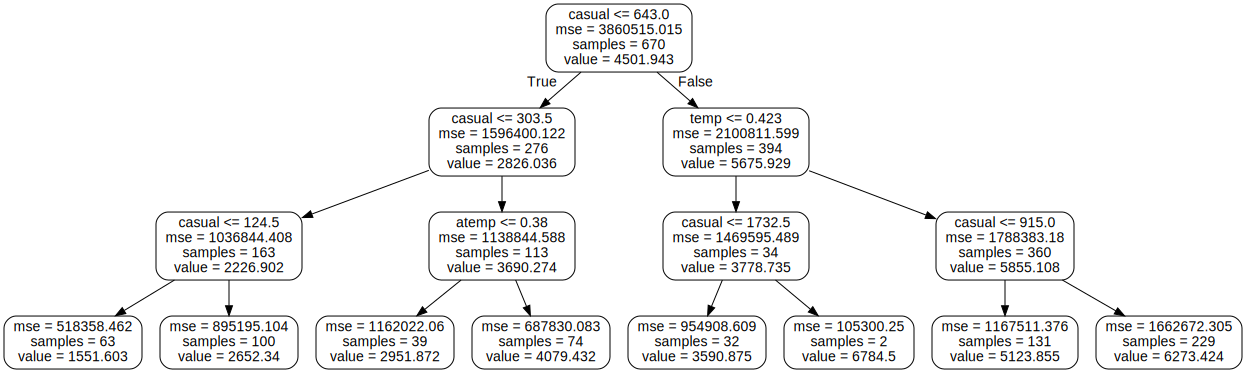

In [53]:
dot_data = tree.export_graphviz(regressor, out_file=None, 
                     feature_names=X.columns,
                     filled=False, rounded=True,  
                     special_characters=False)  
graph = graphviz.Source(dot_data)  
graph 

In [54]:
graph.format = 'png'
graph.render(filename='bike_share_tree_sk', directory='./', cleanup=True)

'.\\bike_share_tree_sk.png'